# Creating a model using resnet50

In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model

In [2]:
# Define data directories
train_dir = 'catagories/train/'
validation_dir = 'catagories/validation/'
test_dir = 'catagories/test'


In [3]:
# Set batch size
batch_size = 32

inputShape=(224, 224, 3)

# Load pre-trained model (excluding top layers)
base_model = ResNet50V2(weights='imagenet', include_top=False, input_shape=inputShape)

# Freeze the base model
base_model.trainable = False


2024-04-10 19:12:45.929065: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2024-04-10 19:12:45.929089: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2024-04-10 19:12:45.929094: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2024-04-10 19:12:45.929133: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-04-10 19:12:45.929148: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


94668760/94668760 [==============================] - 12s 0us/step


In [4]:

# Add new classification layers
x = Flatten()(base_model.output)
x = Dense(256, activation='relu')(x)
output = Dense(4, activation='softmax')(x)



In [5]:
# Preprocess images and apply data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

validation_datagen = ImageDataGenerator(rescale=1./255)


In [6]:
# Create the model
model = Model(inputs=base_model.input, outputs=output)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [7]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',
    classes=['docks', 'object', 'persons', 'place'])  # Update with your class names

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',
    classes=['docks', 'object', 'persons', 'place'])  # Update with your class names



Found 1137 images belonging to 4 classes.
Found 243 images belonging to 4 classes.


In [8]:
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=10,
    verbose=1,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size)


Epoch 1/10


2024-04-10 19:13:02.318596: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


35/35 [==============================] - ETA: 0s - loss: 14.9686 - accuracy: 0.9095

2024-04-10 19:14:09.528229: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


35/35 [==============================] - 82s 2s/step - loss: 14.9686 - accuracy: 0.9095 - val_loss: 4.0159 - val_accuracy: 0.9643
Epoch 2/10
35/35 [==============================] - 77s 2s/step - loss: 2.9322 - accuracy: 0.9683 - val_loss: 3.4307 - val_accuracy: 0.9732
Epoch 3/10
35/35 [==============================] - 78s 2s/step - loss: 2.1494 - accuracy: 0.9719 - val_loss: 3.4178 - val_accuracy: 0.9688
Epoch 4/10
35/35 [==============================] - 78s 2s/step - loss: 1.9349 - accuracy: 0.9729 - val_loss: 5.0027 - val_accuracy: 0.9643
Epoch 5/10
35/35 [==============================] - 78s 2s/step - loss: 0.7310 - accuracy: 0.9855 - val_loss: 1.4178 - val_accuracy: 0.9866
Epoch 6/10
35/35 [==============================] - 79s 2s/step - loss: 1.0860 - accuracy: 0.9810 - val_loss: 3.0756 - val_accuracy: 0.9777
Epoch 7/10
35/35 [==============================] - 78s 2s/step - loss: 1.0777 - accuracy: 0.9819 - val_loss: 2.7373 - val_accuracy: 0.9821
Epoch 8/10
35/35 [============

In [9]:
# Evaluate the model on test data
test_generator = validation_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',
    classes=['docks', 'object', 'persons', 'place'],  # Update with your class names
    shuffle=False)


Found 248 images belonging to 4 classes.


In [10]:
test_loss, test_acc = model.evaluate(test_generator,verbose=0)
print("Test accuracy:", test_acc)

Test accuracy: 0.9596773982048035


In [11]:
model.save('resnet50_model.h5')

/Users/dheemankumar/github/pc-clener/env/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [12]:
import matplotlib.pyplot as plt

def plot_history(history):
    # Plot training & validation accuracy values
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy (ResNet50)')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss (ResNet50)')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()


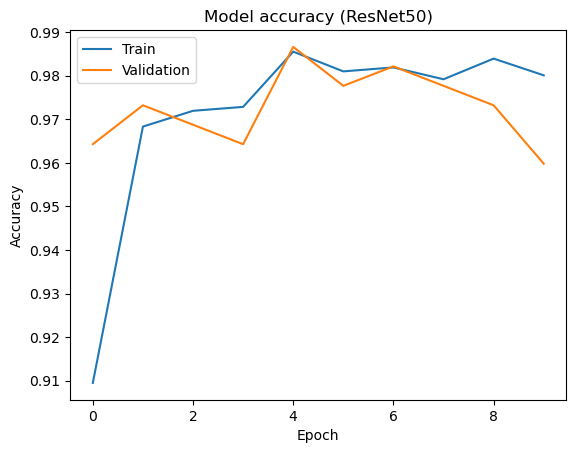

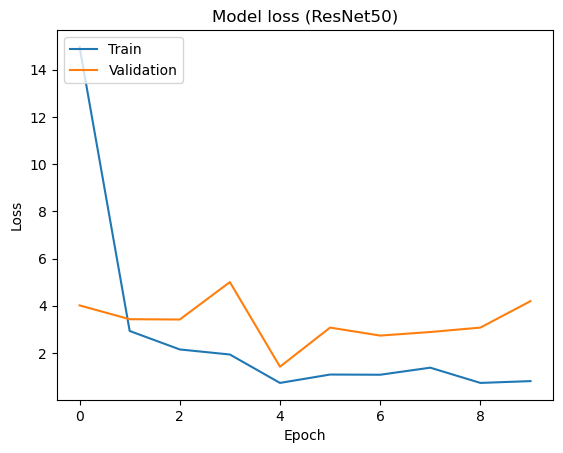

In [13]:
plot_history(history)